In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from tyssue.generation import generate_ring
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec

from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.models.display import (print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference, create_organo)
from tyssue_taylor.adjusters.adjust_annular import prepare_tensions, adjust_parameters
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.adjusters.force_inference import infer_forces, opt_sum_lambda

Using TensorFlow backend.


Reseting datasets values with new specs


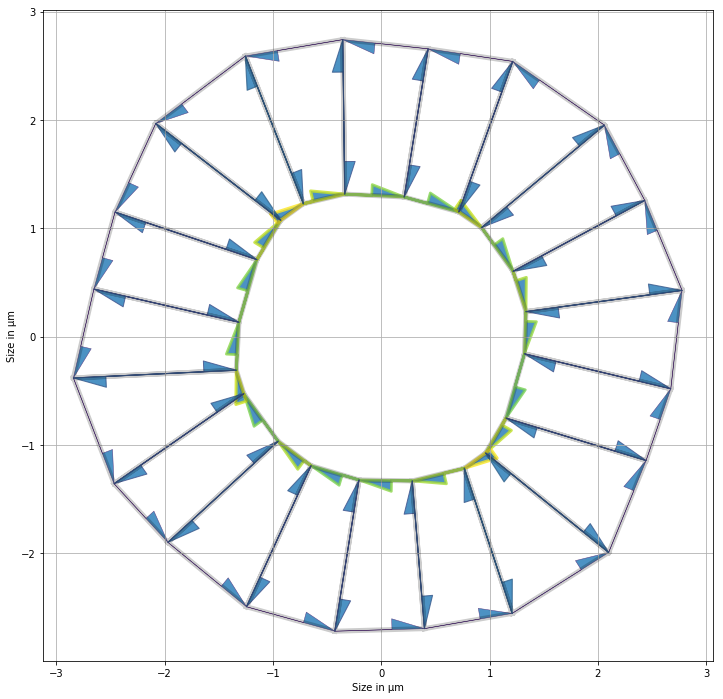

In [2]:
nf, r_in, r_out = (20, 1, 2)
seed = 1
organo = create_organo(nf, r_in, r_out)

organo.edge_df.loc[organo.apical_edges, 'line_tension'] = [
    0.101, 0.115, 0.126, 0.110, 0.105,
    0.102, 0.112, 0.102, 0.118, 0.105,
    0.104, 0.115, 0.127, 0.116, 0.106,
    0.103, 0.117, 0.105, 0.111, 0.107
]

organo.edge_df.loc[organo.basal_edges, 'line_tension'] = [
    0.01, 0.011, 0.012, 0.011, 0.01,
    0.01, 0.011, 0.01, 0.011, 0.01,
    0.01, 0.011, 0.012, 0.011, 0.01,
    0.01, 0.011, 0.01, 0.011, 0.01
]

organo.edge_df.loc[organo.lateral_edges, 'line_tension'] = np.array([
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03
])

organo.face_df.loc[:, 'prefered_area'] = np.array([
    0.08, 0.07, 0.08, 0.09, 0.09,
    0.10, 0.09, 0.08, 0.09, 0.09,
    0.10, 0.11, 0.10, 0.11, 0.12,
    0.11, 0.10, 0.09, 0.08, 0.09
]) + organo.face_df.area

geom.update_all(organo)
Solver.find_energy_min(organo, geom, model)
print_tensions(organo, organo)

## Initialisation avec la méthode d'inférence de forces

### Recherche de la valeur optimale pour la somme des tensions

In [3]:
start = time.time()
opt_cst = opt_sum_lambda(organo)
end = time.time() - start
print("Solving time = ", end,
      "   |   x* = ", opt_cst)

Solving time =  47.46339416503906    |   x* =  0.02683830814704468


### Application de la méthode d'inférence de force

Les tensions et les aires de préférences sont inférées. Plus précisément, les termes $A-A_0$ sont inférés.

En plus des contraintes usuelles de l'inférence de forces, on ajoute une contrainte par cellule imposant que la somme des tensions sur ses edges soit égale à une constante $C$.

Pour fixer cette constante, on utilise la formule de Farhadifar où les paramètres $\overline{\Lambda}$ et $\overline{A_0}$ sont calculé dans un organoïde symétrique (aussi appelé régulié).

Le système d'inférence de force est composé de $5N_f$ lignes et $4N_f+1$ colonnes. On le résoud avec NNLS pour garantir la non-négativité des tensions.


Distance from th org to exp org:  0.6543122653073143


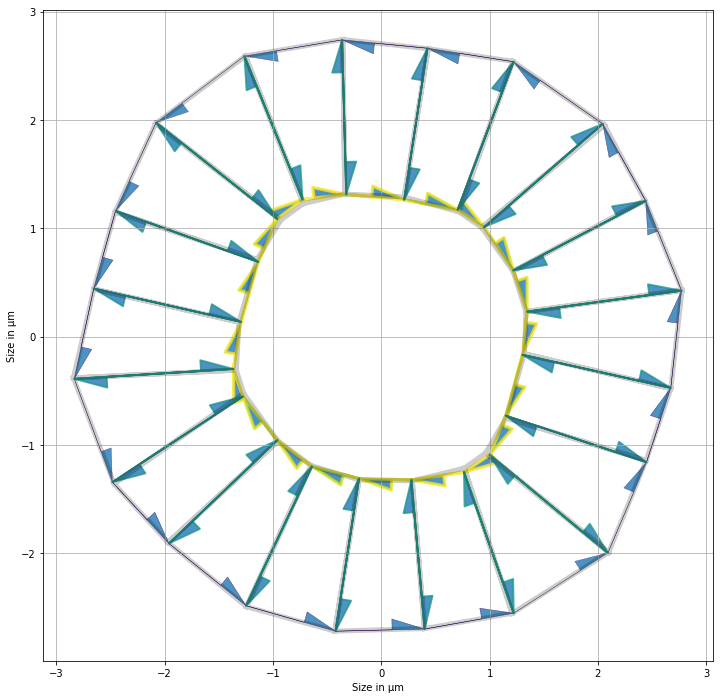

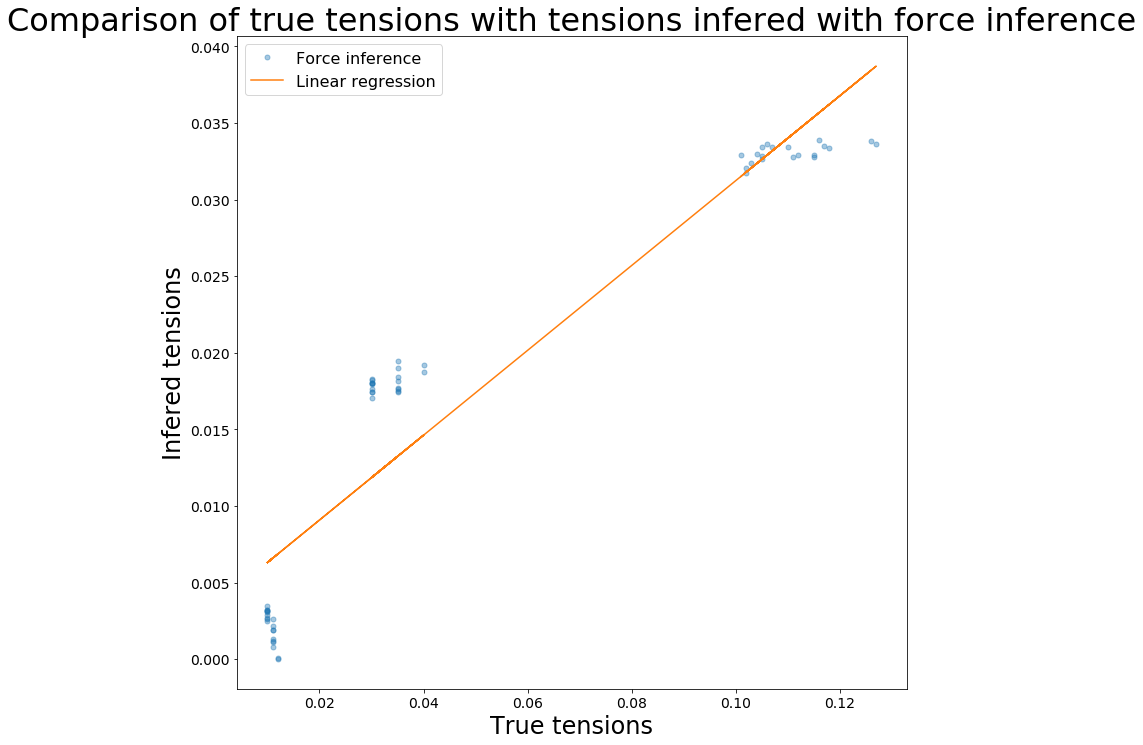

R value : 0.9418074060645715 
Standard error : 0.0036805693991078434


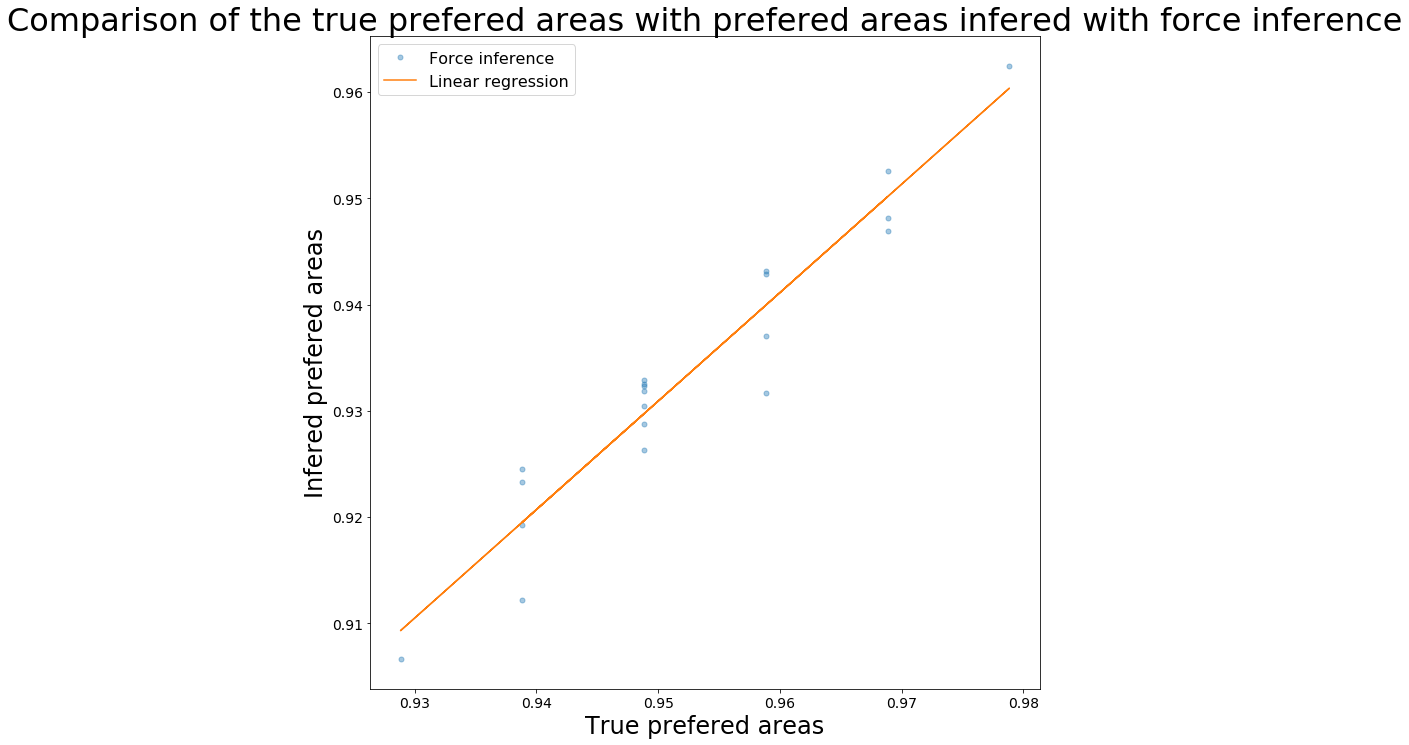

R value : 0.9610499484540543 
Standard error : 0.0018139027970178088


In [4]:
#Calling force inference
fi_init = infer_forces(organo, t_sum=opt_cst)
fi_t = fi_init['tensions']
fi_a = fi_init['areas']
organo_fi = organo.copy()
#Setting fi results in the mesh
organo_fi.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo_fi, fi_t)
organo_fi.face_df.loc[:, 'prefered_area'] = organo_fi.face_df.area + fi_a[:-1]
organo_fi.settings['lumen_prefered_vol'] = organo_fi.settings['lumen_volume'] + fi_a[-1]
#Solving for energy min and displaying
Solver.find_energy_min(organo_fi, geom, model)
print_tensions(organo_fi, organo)
print('\nDistance from th org to exp org: ', np.sum(_distance(organo_fi, organo)))
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf], fi_t,
                  'Comparison of true tensions with tensions infered with force inference',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))
rendering_results(organo, organo.face_df.prefered_area, fi_a[:-1]+organo.face_df.area,
                  'Comparison of the true prefered areas with prefered areas infered with force inference',
                  'True prefered areas', 'Infered prefered areas', ('Force inference', 'Linear regression'))

## Procédure de recalage

La résolution du problème de recalage est faite avec Levenberg-Marquardt.

In [5]:
start = time.time()
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-4, 'verbose': 0}
# Setting the initial point as the force inference result.
fi_init_array = np.r_[fi_t, organo_fi.face_df.area + fi_a[:-1],
                      organo_fi.settings['lumen_volume'] + fi_a[-1]]
rec_res = adjust_parameters(organo.copy(), fi_init_array, **lm_opt)
end = time.time() - start
print("Solving time = ", end,
      "   |   f(x*) = ", np.sum(rec_res.fun))

Solving time =  824.978013753891    |   f(x*) =  0.04072191469427273



Distance from th org to exp org:  0.04072191469427273


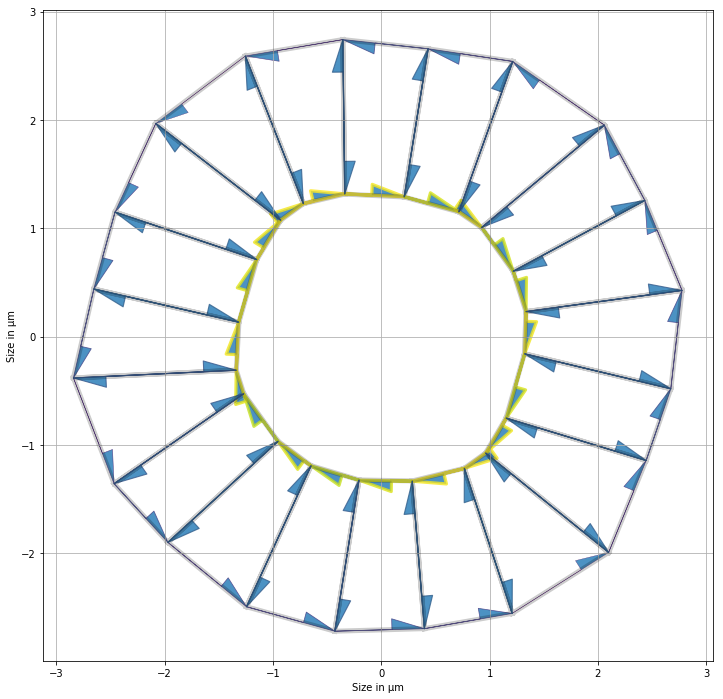

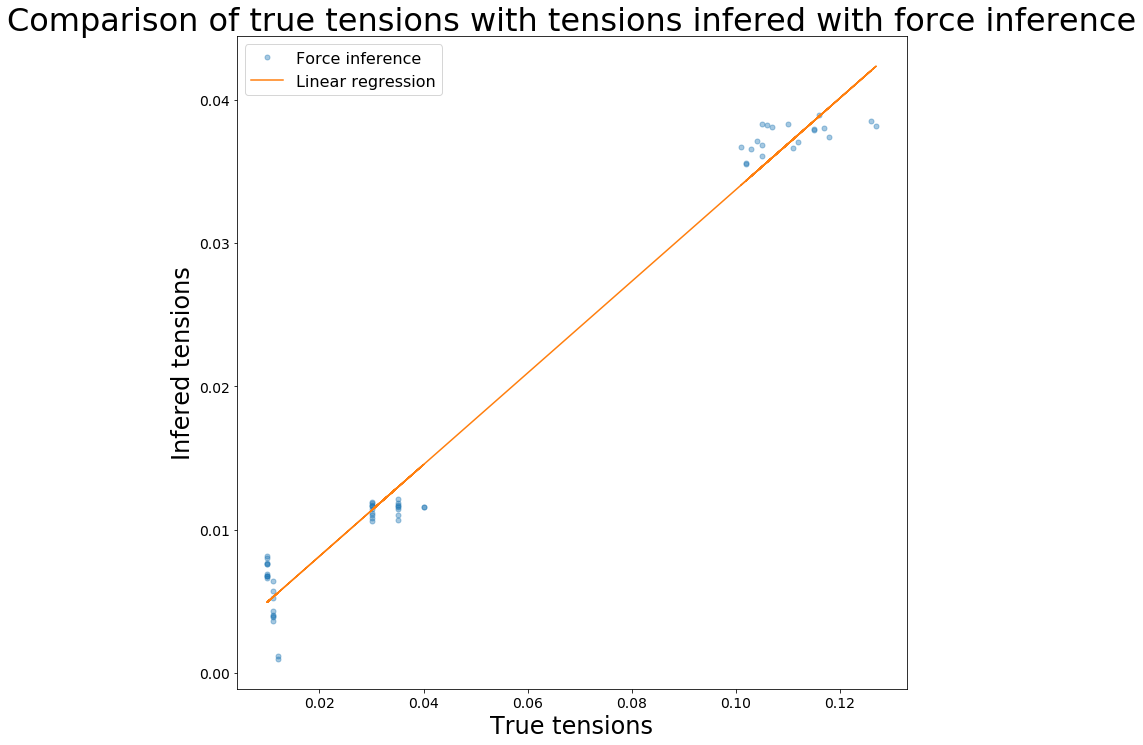

R value : 0.9901622578211307 
Standard error : 0.0016827090891463592


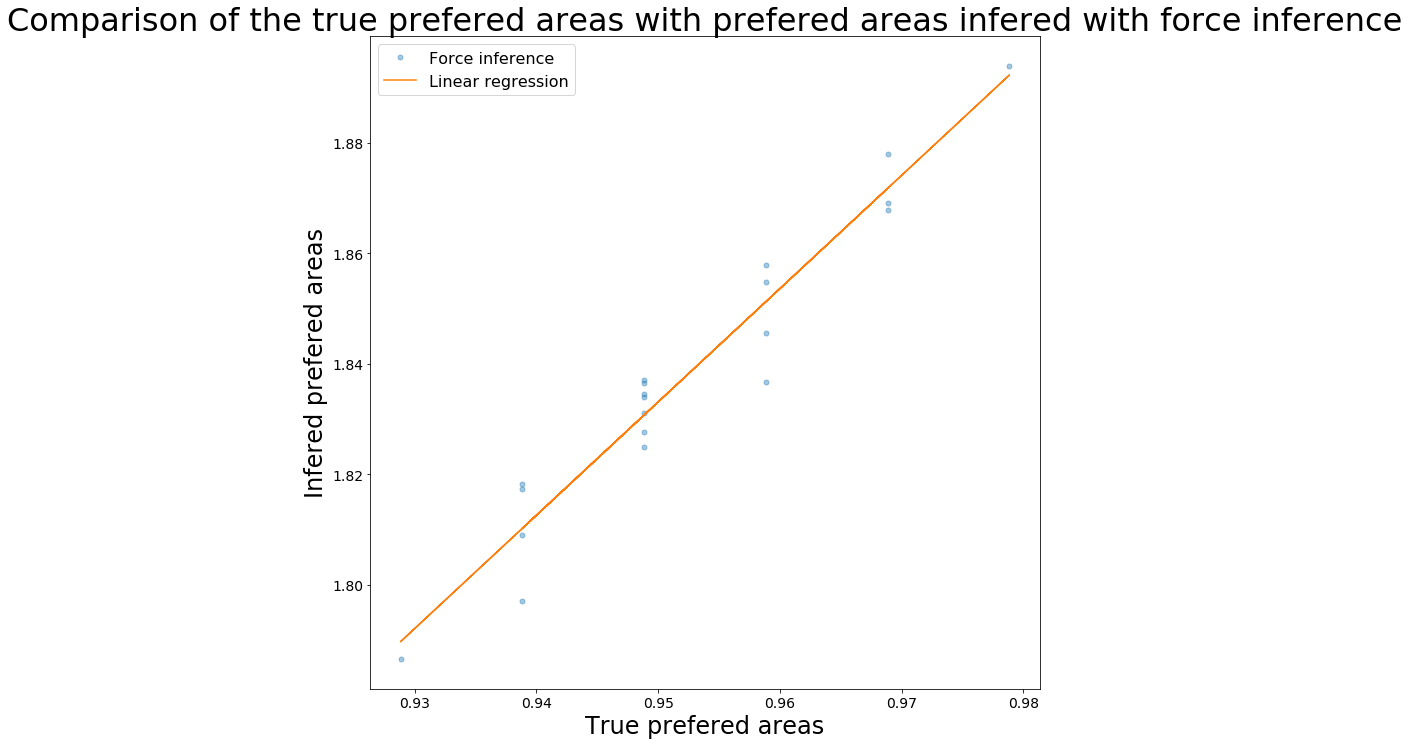

R value : 0.9700268702172362 
Standard error : 0.003172549217718916


In [6]:
rec_t = rec_res.x[:organo.Nf*3]
rec_a = rec_res.x[-(organo.Nf+1):]

organo_rec = organo.copy()
#Setting fi results in the mesh
organo_rec.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo_rec, rec_t)
organo_rec.face_df.loc[:, 'prefered_area'] = rec_a[:-1]
organo_rec.settings['lumen_prefered_vol'] = rec_a[-1]
#Solving for energy min and displaying
Solver.find_energy_min(organo_rec, geom, model)
print_tensions(organo_rec, organo)
print('\nDistance from th org to exp org: ', np.sum(_distance(organo_rec, organo)))
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf], rec_t,
                  'Comparison of true tensions with tensions infered with force inference',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))
rendering_results(organo, organo.face_df.prefered_area, rec_a[:-1]+organo.face_df.area,
                  'Comparison of the true prefered areas with prefered areas infered with force inference',
                  'True prefered areas', 'Infered prefered areas', ('Force inference', 'Linear regression'))